# In class exercise...Mutual Information 11.30.2020

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## First load in our EEG data like last time...

In [2]:
# load the data...
eeg = np.load('eeg_data01.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 1600 trials and 4102 timepoints per trial sampled
# at 1024Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']

Shape of the big eeg data set:  (1600, 4102)
Sample rate:  1024


## Make a vector that labels each trial as coming from experimental conditions 1,2,3,4

In [3]:
N = data.shape[0]
num_samp_cond = int(N/4)
cond = np.hstack((np.ones(num_samp_cond), np.ones(num_samp_cond)*2, np.ones(num_samp_cond)*3, np.ones(num_samp_cond)*4))

## Now avgerage the data from condition 2, avg the data from condition 3, and plot against the time axis (tx) - we're going to ignore conditions 1 and 4

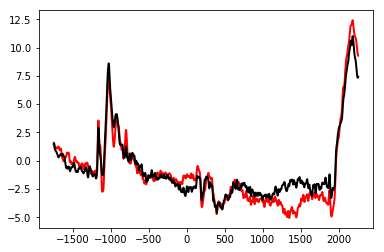

In [4]:
avg1 = np.mean(data[cond==2,:], axis=0)
avg2 = np.mean(data[cond==3,:], axis=0)

plt.plot(tx, avg1, color='r', linewidth=2)
plt.plot(tx, avg2, color='k', linewidth=2)
plt.show()

## Then compute the MI between evoked responses and experimental condition in a specific time window greater than or equal to 1000ms and less than 1500ms post-stimulus onset
* You have one discrete variable (cond, or experimental condition label)
* You have the EEG data from each condition, which is a continuous variable
* First compute the mean response across the time window for each trial of condition 2. This should give you a 400 element array with the mean from each trial across the time window. 
* Then compute the mean response across the time window for each trial of condition 3. 
* Then concatenate the two 400 element arrays to make one 800 element array
* You might also want to create a new set of labels for each trial in your new concatenated array - can relabel conds 2 and 3 with a 0 and 1 for ease of looping...
* Use only 10 bins for computing the pdfs...
* Then compute the MI between experimental condition and EEG responses on each trial!

In [5]:
# get the data from the time window...
td = data[:, (tx>=1000) & (tx<1500)]

# just data from cond 2, meaned across time window
td2 = np.mean(td[cond==2,:], axis=1)
td3 = np.mean(td[cond==3,:], axis=1)

# concatenate
resp = np.hstack((td2, td3))

# check the size to be sure we did this right...
resp.shape

(800,)

In [6]:
# make a new set of labels

# first 1/2 of the data came from condition 1, second half from condition 2

# ntrials in each condition
ntrials = int(resp.shape[0]/2)

stims = np.hstack((np.zeros(ntrials),np.ones(ntrials)))

# check the shape
stims.shape

(800,)

## Now compute Hy...

In [7]:
nbins = 10

py, edges = np.histogram(resp, bins=nbins)

# normalize to unit area
py = py / np.sum(py)

# entropy of y
Hy = -sum(py * np.log2(py))  

print(Hy)

2.7318724527890335


## Now compute Hyx...

In [14]:
#MI = Hy - Hyx

# probability of each discrete variable
px = .5

# get the unique values...
uniquex = np.unique(stims)

# then loop over all possible stims's to compute entropy of continuous 'resp' given each stim (Hyx)
Hyx=0
for j in np.arange(len(uniquex)):

    # grab data from all trials where stims == j
    y_x = resp[stims==j]
    
    # use binning to compute a pdf of y (resp) for this x (stims==j)
    
    # histogram
    tmp_y_x, edges = np.histogram(y_x, bins=nbins)

    # normalize to unit area (PDF)
    tmp_y_x = tmp_y_x / np.sum(tmp_y_x)
    
    # then tally up entropy of y given each specific x multiplied by the probability of that x (px)
    Hyx += px*(-sum( tmp_y_x * np.log2(tmp_y_x) ))
    
print(Hyx)

2.746605841280951


## Now Compute MI - surprise??? What is weird about this?

In [9]:
MI = Hy - Hyx
print(MI)

-0.01473338849191741


## Part II: Bias correction
* MI is biased in that small sample sizes lead to inaccurate estimates of PDFs, and that can sometimes lead to negative MI values (which should never happen in theory). 
* A common, and simple, approach, is to compute MI with shuffled condition labels (like randomization tests that we did many weeks back) and then subtract the shuffled MI from the actual MI. 

## Now repeat the above operations, but shuffle the condition label array and repeat the analysis many times (~500-1000 times). Plot the distribution of MI values that you get.

In [10]:
#MI = Hy - Hyx

rands = 500

# probability of each discrete variable
px = .5

# get the unique values...
uniquex = np.unique(stims)

# allocate array to store Hyx
Hyx=np.zeros(rands)

for i in np.arange(rands):
    
    # shuffle the stimulus condition labels. 
    tmp_stims = np.random.permutation(stims)
    
    # then loop over all possible stims's to compute entropy of continuous 'resp' given each stim (Hyx)
    
    for j in np.arange(len(uniquex)):

        # grab data from all trials where stims == j
        y_x = resp[tmp_stims==j]

        # use binning to compute a pdf of y (resp) for this x (stims==j)

        # histogram 
        tmp_y_x, edges = np.histogram(y_x, bins=nbins)

        # normalize to unit area (PDF)
        tmp_y_x = tmp_y_x / np.sum(tmp_y_x)

        # then tally up entropy of y given each specific x multiplied by the probability of that x (px)
        Hyx[i] += px*(-sum( tmp_y_x * np.log2(tmp_y_x) ))

## Now subtract the mean of the shuffled MI values from your 'real' MI value...this will help correct for any bias that is introduced by a limited sample size

In [11]:
bcMI = MI - (Hy - np.nanmean(Hyx))
print(bcMI)

0.046547683026330944


In [12]:
np.nanmean(Hyx)

2.793153524307282